# 3. fáza - Strojové učenie
## Stahovec - 50%, Viest - 50%
----------------------------------------------------
Základné importy knižníc:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from graphviz import Source
import IPython
from IPython.display import SVG
from IPython.display import HTML
from subprocess import call

pd.options.mode.chained_assignment = None

sns.set_theme(style="whitegrid", palette="viridis")
sns.set_palette("viridis")

Načítanie datasetov zo súborov z predchádzajúcej fázy:

In [2]:
X_test_data = pd.read_csv("dataset/transformed_X_test.csv", sep=",")
X_test_data = X_test_data.iloc[:, 1:]
X_test_data.head(15)

0         1         2         3         4
0   0.367739  0.471250  0.521895  0.367081  0.585875
1   0.408903  0.454163  0.955975  0.891132  0.634517
2   0.614102  0.771766  0.690728  0.296679  0.759758
3   0.747323  0.868591  0.729923  0.385701  0.132010
4   0.264049  0.456017  0.761094  0.873124  0.635221
5   0.615242  0.812390  0.413252  0.522909  0.622408
6   0.298660  0.363822  0.703895  0.822929  0.556999
7   0.530216  0.590720  0.740337  0.683422  0.352738
8   0.346234  0.493798  0.646604  0.721638  0.584239
9   0.301711  0.479263  0.876304  0.632032  0.352850
10  0.832971  0.871989  0.171471  0.377895  0.634516
11  0.443952  0.490043  0.741367  0.557336  0.304470
12  0.678891  0.823725  0.387112  0.586685  0.576501
13  0.651700  0.771592  0.651770  0.286877  0.927072
14  0.871697  0.873862  0.169448  0.512731  0.606361

In [3]:
X_train_data = pd.read_csv("dataset/transformed_X_train.csv", sep=",")
X_train_data = X_train_data.iloc[:, 1:]
X_train_data.head(15)

0         1         2         3         4
0   0.430974  0.634243  0.561645  0.556578  0.595986
1   0.152067  0.400703  0.628397  0.381899  0.310436
2   0.241432  0.535460  0.470687  0.374317  0.618281
3   0.127369  0.228590  0.789454  0.651435  0.690309
4   0.517942  0.702688  0.584291  0.241332  0.726710
5   0.382531  0.552257  0.340768  0.547632  0.311639
6   0.600742  0.794484  0.349163  0.464476  0.349393
7   0.265724  0.537470  0.560907  0.135113  0.700122
8   0.107663  0.357216  0.590500  0.369859  0.344230
9   0.588192  0.765671  0.863311  0.458011  0.231674
10  0.306769  0.292398  0.255592  0.346493  0.262015
11  0.456329  0.523017  0.541773  0.235389  0.494906
12  0.478286  0.565142  0.372899  0.376482  0.239524
13  0.132110  0.542429  0.830745  0.805610  0.551924
14  0.520316  0.635357  0.679616  0.199773  0.579734

In [4]:
Y_test_data = pd.read_csv("dataset/y_test.csv", sep=",")
Y_test_data = Y_test_data.iloc[:, 1:]
Y_test_data.head(15)

indicator
0           1
1           1
2           1
3           0
4           1
5           1
6           1
7           0
8           1
9           0
10          1
11          0
12          1
13          1
14          1

In [5]:
Y_train_data = pd.read_csv("dataset/y_train.csv", sep=",")
Y_train_data = Y_train_data.iloc[:, 1:]
Y_train_data.head(15)

indicator
0           1
1           0
2           1
3           1
4           1
5           1
6           1
7           1
8           0
9           0
10          0
11          1
12          0
13          1
14          1

------------------------------------------------

## 1 - Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

### Funkcia na oneR algoritmus

Do funkcie prídu 2 dataframy, v ktorých upravíme numerické dáta pre jednotlivé intervaly
Napríklad ak je hodnota v intervale 0-0,2 túto hodnotu namapujeme na 0,1. Následne spočítame
najčastejší indikátor pre danú hodnotu. Potom prechádzame po pôvodných a predikovaných dátach
a porovnávame koľkokrát sa predikcia trafila.

Ak sú prítomné argumenty X_test a Y_test, vykoná sa zároveň aj predikcia na skutočnom datasete
s najlepším atribútom a vyhodnotí sa jeho úspešnosť.

In [6]:
def custom_oneR(X_data, Y_data, X_test = None, Y_test = None):
    results = []
    X_set = pd.DataFrame(X_data)
    Y_set = np.squeeze(Y_data)

    most_freq = []

    for i in range(len(X_set.columns)):
        column = set_intervals(X_set[X_set.columns[i]])
        # print(Y_set)
        unique_counts = 0
        # merged_set = pd.concat([X_set[i], Y_set], axis=1)
        merged_set = pd.DataFrame({"variable": column, "label": Y_set})
        most_freq_val = pd.crosstab(column, Y_set).idxmax(axis=1)
        # unique_counts = [0 for _ in range(len(X_set[i].unique()))]

        y_true, y_pred = [], []
        for index, row in merged_set.iterrows():
            if row["label"] == most_freq_val[row["variable"]]:
                # unique_counts[unique_counts.index(index)] += 1
                unique_counts += 1
            y_true.append(row["label"])
            y_pred.append(most_freq_val[row["variable"]])

        current_result = {"variable": X_set.columns[i], "accuracy": unique_counts / len(Y_set), "precision":
            precision_score(y_true, y_pred, average='binary'), "recall": recall_score(y_true, y_pred, average='binary')}
        results.append(current_result)
        most_freq.append(most_freq_val)

    if X_test is not None:
        best_eval = 0
        best_index = 0
        for i in range(len(results)):
            if best_eval < results[i]['accuracy'] + results[i]['precision'] + results[i]['recall']:
                best_eval = results[i]['accuracy'] + results[i]['precision'] + results[i]['recall']
                best_index = i
        column = set_intervals(X_test[X_test.columns[best_index]])

        merged_set = pd.DataFrame({"variable": column, "label": Y_test.squeeze()})
        unique_counts = 0
        y_true, y_pred = [], []
        for index, row in merged_set.iterrows():
            if row["label"] == most_freq[best_index][row["variable"]]:
                # unique_counts[unique_counts.index(index)] += 1
                unique_counts += 1
            y_true.append(row["label"])
            y_pred.append(most_freq[best_index][row["variable"]])
        current_result = {"variable": X_test.columns[best_index], "accuracy": unique_counts / len(Y_test), "precision":
            precision_score(y_true, y_pred, average='binary'), "recall": recall_score(y_true, y_pred, average='binary')}
        print("1R for testing data: ", current_result)
        sns.boxenplot(data=merged_set, x="label", y="variable")
    else:
        for index in range(len(results)):
            print(results[index])
        return results

Funkcia na upravenie nekategorických dát na hodnoty na základe predom zadaného intervalu.
Rozdelí numerické dáta do piatich kategórií.

In [7]:
def set_intervals(data):
    unique_values = data.value_counts().index.tolist()
    if len(unique_values) > len(data) / 2:
        for value in range(len(data)):
            if 0 <= data[value] < 0.2:
                data[value] = 0.1
            elif 0.2 <= data[value] < 0.4:
                data[value] = 0.3
            elif 0.4 <= data[value] < 0.6:
                data[value] = 0.5
            elif 0.6 <= data[value] < 0.8:
                data[value] = 0.7
            else:
                data[value] = 0.9

    return data

In [8]:
"""d = {'outlook': [0, 0, 0.5, 1, 1, 1, 0.5, 0, 0, 1, 0, 0.5, 0.5, 1]}
X_frame = pd.DataFrame(d)
Y_frame = pd.Series([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])
print(Y_frame)
print(X_frame)"""


"d = {'outlook': [0, 0, 0.5, 1, 1, 1, 0.5, 0, 0, 1, 0, 0.5, 0.5, 1]}\nX_frame = pd.DataFrame(d)\nY_frame = pd.Series([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])\nprint(Y_frame)\nprint(X_frame)"

Zavolanie funkcie 1R a vyhodnotenie výsledkov pre všetky atribúty zvlášť.

In [9]:
custom_oneR(X_train_data, Y_train_data)

{'variable': '0', 'accuracy': 0.6950810508664058, 'precision': 0.6875884851344974, 'recall': 0.9570834245675498}
{'variable': '1', 'accuracy': 0.6581889323644494, 'precision': 0.662379421221865, 'recall': 0.9472301291876505}
{'variable': '2', 'accuracy': 0.7266629401900503, 'precision': 0.7068610362858501, 'recall': 0.9767900153273483}
{'variable': '3', 'accuracy': 0.6382057015092231, 'precision': 0.6382057015092231, 'recall': 1.0}
{'variable': '4', 'accuracy': 0.8528507546115148, 'precision': 0.8585714285714285, 'recall': 0.9211736369608058}


[{'variable': '0',
  'accuracy': 0.6950810508664058,
  'precision': 0.6875884851344974,
  'recall': 0.9570834245675498},
 {'variable': '1',
  'accuracy': 0.6581889323644494,
  'precision': 0.662379421221865,
  'recall': 0.9472301291876505},
 {'variable': '2',
  'accuracy': 0.7266629401900503,
  'precision': 0.7068610362858501,
  'recall': 0.9767900153273483},
 {'variable': '3',
  'accuracy': 0.6382057015092231,
  'precision': 0.6382057015092231,
  'recall': 1.0},
 {'variable': '4',
  'accuracy': 0.8528507546115148,
  'precision': 0.8585714285714285,
  'recall': 0.9211736369608058}]

---

## 2 - Natrénovanie a vyhodnotenie klasifikátora strojového učenia

### 2.1, 2.2 - Vytvorenie rozhodovacích stromov (Decision Tree, RandomForest) a následná vizualizácia týchto stromov

Vytvorenie stromu pomocou DecisionTreeClassifier funkcie.
Vizuálna podoba stromu je zároveň uložená vo formáte .png.

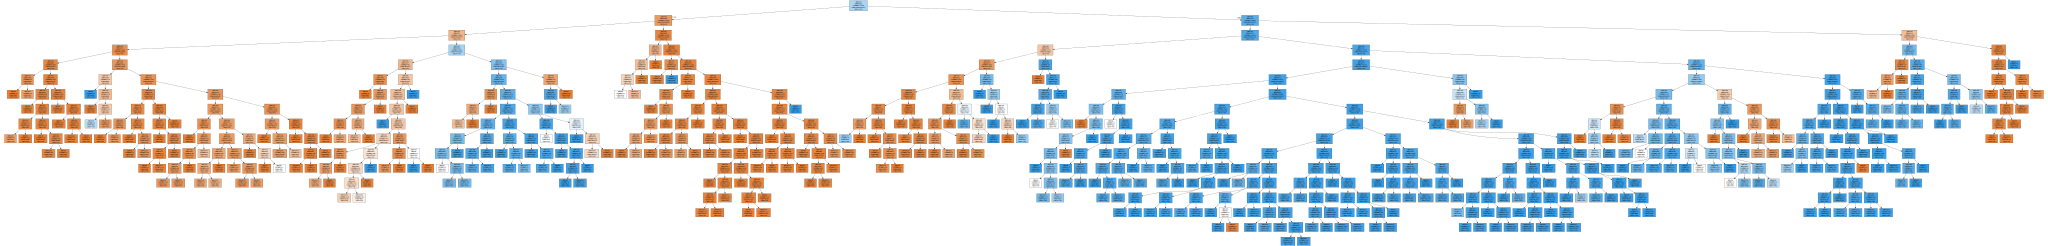

In [10]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_data, Y_train_data)
graph = Source(export_graphviz(clf, out_file=None, class_names=['no', 'yes'],
                               filled = True))

png_bytes = graph.pipe(format='png')
with open('tree/DecisionTree.png','wb') as f:
    f.write(png_bytes)


IPython.display.display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:500% !important;height:500% !important;}</style>"
HTML(style)

Vytvorenie stromu pomocou RandomForestClassifier funkcie.
V tomto prípade je použití iný spôsob uloženia vizuálnej
podoby stromu.

In [11]:
clf_RFC = RandomForestClassifier()
clf_RFC = clf_RFC.fit(X_train_data, Y_train_data)

clf_RFC_one = clf_RFC.estimators_[0]

graph = export_graphviz(clf_RFC_one, out_file='tree.dot', class_names=['no','yes'],
                rounded=True, filled=True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree/RandomForest.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree/RandomForest.png')


C:\Users\PC\AppData\Local\Temp/ipykernel_4148/320761453.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_RFC = clf_RFC.fit(X_train_data, Y_train_data)


Výpis dôležitostí pre jednotlivé atribúty podľa RandomForestClassifier-u.

In [12]:
clf_RFC.feature_importances_

array([0.13341878, 0.0467964 , 0.20854195, 0.08071903, 0.53052384])

# 2.3 - Vyhodnotenie natrénovaných modelov

Funkcia na vypočítanie accuracy score, presicion score a recall score na základe
predikcie a dataframov.

In [13]:
def calculate_scores(fitted_data, X_data, Y_data):
    prediction = fitted_data.predict(X_data)
    print("Accuracy score: ", accuracy_score(Y_data, prediction))
    print("Precision score: ", precision_score(Y_data, prediction, average='binary'))
    print("Recall score: ", recall_score(Y_data, prediction, average='binary'))


## Decision tree na trénovacej sade

Predikcia a evaluácia pre decision tree na trénovacej sade:

In [14]:
calculate_scores(clf, X_train_data, Y_train_data)

#prediction = clf.predict(X_train_data)
#print(accuracy_score(Y_train_data, prediction))

Accuracy score:  0.9434041363890442
Precision score:  0.9494600431965443
Recall score:  0.9625574775563828


## Decision tree na testovacej sade

Predikcia a evaluácia pre **Decision Tree** na testovacej sade:

In [15]:
calculate_scores(clf, X_test_data, Y_test_data)

#prediction = clf.predict(X_test_data)
#print(accuracy_score(Y_test_data, prediction), precision_score(Y_test_data, prediction, average='binary'),
#      recall_score(Y_test_data, prediction, average='binary'))

Accuracy score:  0.9383906119027662
Precision score:  0.9497422680412371
Recall score:  0.9552819183408944


## Random forest

Predikcia a evaluácia pre **Random Forest**:

In [16]:
calculate_scores(clf_RFC, X_test_data, Y_test_data)

#prediction = clf_RFC.predict(X_test_data)
#print(accuracy_score(Y_test_data, prediction), precision_score(Y_test_data, prediction, average='binary'),
#     recall_score(Y_test_data, prediction, average='binary'))

Accuracy score:  0.9430008382229673
Precision score:  0.9518304431599229
Recall score:  0.9604666234607907


## 2.4 Porovnanie Decision Tree s 1R

Porovnanie úspešnosti Decision Tree a 1R na rovnakej testovacej sade:

In [17]:
calculate_scores(clf, X_test_data, Y_test_data)

Accuracy score:  0.9383906119027662
Precision score:  0.9497422680412371
Recall score:  0.9552819183408944


1R for testing data:  {'variable': '4', 'accuracy': 0.8679798826487846, 'precision': 0.8753056234718827, 'recall': 0.9280622164614387}


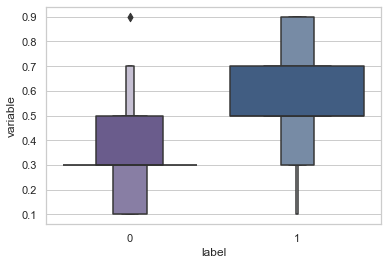

In [18]:
custom_oneR(X_train_data, Y_train_data, X_test_data, Y_test_data)

Ako možno vidieť na výsledkoch pre algoritmus oneR, tak jeho úspešnosť je nižšie o cca 7%,
ako tomu bolo pri **Decision Tree**. Tento výsledok je očakávaný, keďže náš oneR v tomto
prípade používa iba jeden atribút na predikciu hodnoty indikátora. Na druhú stranu Decision
Tree zohľadňuje všetky atribúty a prepojenia medzi nimi, vďaka čomu nadobúda značnú výhodu.

Atribút zvolený algoritmom oneR sme zobrazili boxplotom, ktorý ukazuje disproporčnosť
pri rôznej hodnote indikátora. Vďaka tejto súvislosti vykonával oneR jednoduché rozhodnutia
s uspokojivou úspešnosťou.

## 3 Optimalizácia - hyperparameter tuning

## 3.1 - Rôzne nastavenia hyperparametrov

V týchto krokoch skúmame rôzne hyperparametre a pozeráme sa, ako sa **accuracy**, **precision**
a **recall** hodnody menia.

V tomto kroku sme zmenili maximálnu hlbku stromu na 3 úrovne.

In [19]:
md_tree = DecisionTreeClassifier(max_depth=3)
md_tree.fit(X_train_data, Y_train_data)

calculate_scores(md_tree, X_test_data, Y_test_data)

Accuracy score:  0.9233025984911987
Precision score:  0.9151404151404151
Recall score:  0.9714841218405703


V tomto kroku sme zmenili kritérium pri splitovaní stromu na entropy.

In [20]:
diff_crit_tree = DecisionTreeClassifier(criterion="entropy")
diff_crit_tree.fit(X_train_data, Y_train_data)

calculate_scores(diff_crit_tree, X_test_data, Y_test_data)

Accuracy score:  0.9388097233864208
Precision score:  0.950354609929078
Recall score:  0.9552819183408944


V tomto kroku sme zmenili hodnotu pre rozvetvovanie stromu.

In [21]:
min_leaf_tree = DecisionTreeClassifier(min_samples_leaf=20)
min_leaf_tree.fit(X_train_data, Y_train_data)

calculate_scores(diff_crit_tree, X_test_data, Y_test_data)

Accuracy score:  0.9388097233864208
Precision score:  0.950354609929078
Recall score:  0.9552819183408944


Ako je možné vidieť, hodnoty s meniacimi sa kritériami sa veľmi nemenia. Tento fakt môže byť
spôsobený tým, že sme akurát trafili konfigurácie, kedy algoritmus nájde najlepšie riešenia.

## 3.2 - Vysvetlenie hyperparametrov a krížová validácia

V tomto kroku skúšame viacero konfigurácii, ktoré medzi sebou tvoria permutácie, na základe
ktorých vie algoritmus určiť najlepšie podmienky pre učenie.

Tu si určíme parametre, ktoré sa medzi sebou majú kombinovať

* maxdepth -> maximálna hlbka stromu, najdlhšia možná vetva
* min_samples_leaf -> najmenšie množstvo vzoriek, ktoré sú potrebné, na to, aby sa strom ďalej rozvetvoval
* criterion -> funkcia na meranie kvality rozvetvenia, pri **Gini** sa pozerá na "čistotu dát", pri **Entropy** na množstvo získaných informácii
* max_features -> počet atribútov, ktoré sa berú do úvahy

In [22]:
params = {
    'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
    'min_samples_leaf': [3, 5, 10, 20, 40],
    'criterion': ["gini", "entropy"],
    'max_features': [2, 3, 4, 5]
}

## Krížová validácia

Tu voláme funkciu, ktorá vytvára permutácie konfigurácii a hľadá najlepšie nastavenie pre
Decision Tree.

In [23]:
grid_search = GridSearchCV(estimator=clf,
                           param_grid=params,
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [24]:
grid_search.fit(X_train_data, Y_train_data)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [3, 5, 10, 20, 40]},
             scoring='accuracy', verbose=1)

Výpis dataframu z výsledkov z volania grid-search-u.

In [25]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head(100)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.010602      0.004271         0.005004        0.001262   
1        0.011004      0.000898         0.004008        0.000890   
2        0.011602      0.002583         0.004597        0.001345   
3        0.019004      0.009596         0.004222        0.001167   
4        0.014185      0.008077         0.004399        0.001742   
..            ...           ...              ...             ...   
95       0.014795      0.002313         0.004010        0.001089   
96       0.021008      0.012283         0.003198        0.000399   
97       0.015997      0.004430         0.003600        0.000487   
98       0.015394      0.006886         0.005406        0.002795   
99       0.015608      0.004912         0.004202        0.002409   

   param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0             gini               3                  2                      3   
1             gini               3                  2                      5   
2             gini               3                  2                     10   
3             gini               3                  2                     20   
4             gini               3                  2                     40   
..             ...             ...                ...                    ...   
95            gini              13                  5                      3   
96            gini              13                  5                      5   
97            gini              13                  5                     10   
98            gini              13                  5                     20   
99            gini              13                  5                     40   

                                               params  split0_test_score  \
0   {'criterion': 'gini', 'max_depth': 3, 'max_fea...           0.824022   
1   {'criterion': 'gini', 'max_depth': 3, 'max_fea...           0.878492   
2   {'criterion': 'gini', 'max_depth': 3, 'max_fea...           0.884777   
3   {'criterion': 'gini', 'max_depth': 3, 'max_fea...           0.886173   
4   {'criterion': 'gini', 'max_depth': 3, 'max_fea...           0.868715   
..                                                ...                ...   
95  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.935056   
96  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.939246   
97  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.935754   
98  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.932961   
99  {'criterion': 'gini', 'max_depth': 13, 'max_fe...           0.923883   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.867226           0.888190           0.883298   
1            0.877009           0.874913           0.844864   
2            0.865129           0.872816           0.902166   
3            0.907058           0.878407           0.726765   
4            0.860936           0.883298           0.875611   
..                ...                ...                ...   
95           0.944794           0.925926           0.931516   
96           0.945493           0.929420           0.931516   
97           0.941999           0.928022           0.931516   
98           0.939203           0.927324           0.932215   
99           0.937806           0.917540           0.918239   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.831586         0.858865        0.026401              353  
1            0.878407         0.870737        0.013001              351  
2            0.888190         0.882616        0.012804              342  
3            0.858141         0.851309        0.064212              354  
4            0.865129         0.870738        0.007914              350  
..                ...              ...             ...              ...  
95           0.932215         0.933901

Výpis najlepšieho indexu z dataframe:

In [26]:
grid_search.best_index_

111

Výpis najlepšej konfigurácie z dataframe:

In [27]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=16, max_features=4, min_samples_leaf=5)

Výpis accuracy, precision a recall skore pre najlepšiu konfiguráciu:

In [28]:
best_estimator = grid_search.best_estimator_

calculate_scores(best_estimator, X_test_data, Y_test_data)

Accuracy score:  0.9430008382229673
Precision score:  0.9535783365570599
Recall score:  0.9585223590408296


# 4 - Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

Identická funkcia na transformáciu a škálovanie datasetu z druhej fázy, ktorá
bude použitá neskôr.

In [29]:
def transform_and_scale_dataset(dataset):
    pipeline = Pipeline([('power', PowerTransformer(method='yeo-johnson', standardize=False)),
                         ('scaler', MinMaxScaler())])
    print(pipeline)
    pipeline.fit(dataset)
    transformed = pipeline.transform(dataset)
    #transformed.columns = dataset.columns.copy()

    return transformed


Funkcia na výber atribútov z druhej fázy:

In [30]:
def feature_selection_model(data_X, data_Y):
    selector = SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=5).fit(data_X, data_Y)
    print(selector.estimator_.coef_)
    print(selector.threshold_)
    print(selector.get_support())

    X_new = selector.transform(data_X)
    print(X_new.shape)

    return X_new, selector.get_support()

Funkcia na rozdelenie dát na 4 časti do trénovacích a testovacích sád:

In [31]:
def split_data(dataset, size, state):
    X_nonindicator = dataset.loc[:, dataset.columns != "indicator"]
    y_indicator = dataset[["indicator"]]
    X_training, X_testing, y_training, y_testing = train_test_split(X_nonindicator, y_indicator,
                                                        test_size=size, random_state=state)
    return X_training, X_testing, y_training, y_testing

Grid search funkcia na krížovú validáciu, natrénovanie a vyhodnotenie estimátora:

In [32]:
def grid_search_function(tree, X_set, Y_set, params):

    grid_search = GridSearchCV(estimator=tree,
                           param_grid=params,
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

    grid_search.fit(X_set, Y_set)

    best_estimator = grid_search.best_estimator_

    print("Best estimator: ", best_estimator)

    calculate_scores(best_estimator, X_set, Y_set)

    return best_estimator


## 4.1 - Stratégie riešenia chýbajúcich hodnôt a outlierov

Narozdiel od fázy 2 sme nahradili chýbajúce hodnoty priemerom a outlierov sme dropli.

Načítanie dát zo súboru:

In [33]:
old_data = pd.read_csv("dataset/merged_data_3phase.csv", sep=",")
old_data = old_data.iloc[:, 1:]

old_data

smoker    hbver  erytrocyty      alt  leukocyty    etytr  hemoglobin  \
0          1  4.98718     8.89463  2.40520    5.75830  6.93712     4.54976   
1          0  5.00648     7.27841  0.82563    5.54481  5.03221     7.70354   
2          1  6.71966     7.01351  1.00377    5.66778  5.12799     7.73316   
3          1  6.67732     4.21847  0.66072    6.29064  5.19990     4.10863   
4          1  6.06875     5.68453  0.58818    3.90764  5.87943     6.89656   
...      ...      ...         ...      ...        ...      ...         ...   
9867       1  5.56044     7.88598  1.25698    6.44806  4.91910     5.42717   
9868       0  6.02362     4.17512  0.51225    5.81361  5.63849     4.22984   
9869       1  5.63262     5.74856  0.39597    7.16376  5.98503     7.57294   
9870       0  6.74328     7.27587  0.98270    4.87883  4.79271     6.66698   
9871       0  6.86725     4.30972  0.51116    6.29241  4.86855     5.20810   

              ssn           name_x  trombocyty  ...       ast  hematokrit  \
0     021-87-4523    Jeremy Tanner     6.23782  ...  51.62366     3.34206   
1     021-87-4523    Jeremy Tanner     7.42732  ...  59.24840     6.85814   
2     021-87-4523    Jeremy Tanner     5.42279  ...  46.12997     6.78850   
3     513-39-9691    Jocelyn Kelly     6.27100  ...  61.59374     5.78180   
4     513-39-9691    Jocelyn Kelly     7.03818  ...  64.44051     8.14506   
...           ...              ...         ...  ...       ...         ...   
9867  774-29-8698      Stacy Young     5.95845  ...  56.75972     6.44557   
9868  774-29-8698      Stacy Young     5.86267  ...  35.73155     5.78540   
9869  461-85-3049  Jason Santos MD     6.82832  ...  51.29995     7.69555   
9870  461-85-3049  Jason Santos MD     8.27491  ...  27.24570     7.23617   
9871  461-85-3049  Jason Santos MD     6.20019  ...  57.37140     5.70687   

       birthdate                                      address  race  \
0     1923-05-10             PSC 7581, Box 0898  APO AA 06225     0   
1     1923-05-10             PSC 7581, Box 0898  APO AA 06225     0   
2     1923-05-10             PSC 7581, Box 0898  APO AA 06225     0   
3     1923-12-08  175 Anita Pass  Lake Davidchester, NC 93833     0   
4     1923-12-08  175 Anita Pass  Lake Davidchester, NC 93833     0   
...          ...                                          ...   ...   
9867  1990-10-21      5329 Green Circle  West Janet, CO 94192     4   
9868  1990-10-21      5329 Green Circle  West Janet, CO 94192     4   
9869  1916-02-13   4749 Ashley Mission  New Natalie, ME 97315     4   
9870  1916-02-13   4749 Ashley Mission  New Natalie, ME 97315     4   
9871  1916-02-13   4749 Ashley Mission  New Natalie, ME 97315     4   

           current_location  blood_group           name_y sex  \
0      56.944534, 42.355764            4    Jeremy Tanner   1   
1      56.944534, 42.355764            4    Jeremy Tanner   1   
2      56.944534, 42.355764            4    Jeremy Tanner   1   
3      84.160623, 21.685531            6    Jocelyn Kelly   0   
4      84.160623, 21.685531            6    Jocelyn Kelly   0   
...                     ...          ...              ...  ..   
9867   89.633417, 92.757661            4      Stacy Young   0   
9868   89.633417, 92.757661            4      Stacy Young   0   
9869  60.916302, -46.237649            6  Jason Santos MD   1   
9870  60.916302, -46.237649            6  Jason Santos MD   1   
9871  60.916302, -46.237649            6  Jason Santos MD   1   

                                              residence  
0               6041 Henry Inlet  Harrishaven, KS 63783  
1               6041 Henry Inlet  Harrishaven, KS 63783  
2               6041 Henry Inlet  Harrishaven, KS 63783  
3     04425 Wilson Crescent Apt. 364  Lisashire, WY ...  
4     04425 Wilson Crescent Apt. 364  Lisashire, WY ...  
...                                                 ...  
9867  3827 Sullivan Manor Suite 578  Joehaven, ID 19902  
9868  3827 Sullivan Manor Suite 578  Joehaven,

Vypočítanie IQR pre identifikáciu outlierov.

In [34]:
def iqr_calc(dataframe, column, boxplot=True):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Whisker = Q1-1.5*IQR if Q1-1.5*IQR > 0 else 0
    Upper_Whisker = Q3+1.5*IQR

    if boxplot:
        sns.boxplot(x=dataframe[column])

    return Lower_Whisker, Upper_Whisker

Kombinácia viacerých buniek z druhej fázy do jednej funkcie, ktorá nahradí
chýbajúce hodnoty priemerom a dropne outlierov.

In [35]:
def change_data(data):

    data = data.fillna(data.mean())

    for column in data.describe().columns:
        lower, upper = iqr_calc(data, column, False)
        outliers = []
        for row in data[column]:
            if row < lower or row > upper:
                outliers.append(np.nan)
            else:
                outliers.append(row)
        data[column] = outliers

    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)

    data["indicator"] = data["indicator"].astype(int)
    data.drop(data.select_dtypes(include = {'object', 'datetime64'}), axis = 1, inplace = True)

    return data

Vykonanie všetkých zmien:

In [36]:
old_data = change_data(old_data)

old_data

C:\Users\PC\AppData\Local\Temp/ipykernel_4148/257734717.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())


smoker    hbver  erytrocyty      alt  leukocyty     etytr  hemoglobin  \
0          0  5.00648     7.27841  0.82563    5.54481  5.032210     7.70354   
1          1  6.71966     7.01351  1.00377    5.66778  5.127990     7.73316   
2          1  6.67732     4.21847  0.66072    6.29064  5.199900     4.10863   
3          1  6.06875     5.68453  0.58818    3.90764  5.879430     6.89656   
4          1  6.05162     6.77173  0.45377    4.84219  5.318937     6.35723   
...      ...      ...         ...      ...        ...       ...         ...   
7975       1  5.56044     7.88598  1.25698    6.44806  4.919100     5.42717   
7976       0  6.02362     4.17512  0.51225    5.81361  5.638490     4.22984   
7977       1  5.63262     5.74856  0.39597    7.16376  5.985030     7.57294   
7978       0  6.74328     7.27587  0.98270    4.87883  4.792710     6.66698   
7979       0  6.86725     4.30972  0.51116    6.29241  4.868550     5.20810   

      trombocyty       alp  relationship  indicator     er-cv     weight  \
0        7.42732  50.72980             1          1  62.99586  146.16135   
1        5.42279  54.52797             1          1  61.66052   90.39084   
2        6.27100  20.30249             4          0  45.34617   81.56533   
3        7.03818  84.46671             4          1  45.02880   93.78428   
4        5.20885  85.68068             0          1  46.19759  106.98126   
...          ...       ...           ...        ...       ...        ...   
7975     5.95845  71.09634             4          1  62.05093   96.06221   
7976     5.86267  33.94788             3          0  61.71716   43.58221   
7977     6.82832  54.70713             5          1  82.43138   18.29813   
7978     8.27491  81.65971             2          1  62.57684  113.12563   
7979     6.20019  69.75581             0          0  29.97987   60.62351   

           ast  hematokrit  race  blood_group  sex  
0     59.24840     6.85814     0            4    1  
1     46.12997     6.78850     0            4    1  
2     61.59374     5.78180     0            6    0  
3     64.44051     8.14506     0            6    0  
4     38.20747     5.74776     0            6    0  
...        ...         ...   ...          ...  ...  
7975  56.75972     6.44557     4            4    0  
7976  35.73155     5.78540     4            4    0  
7977  51.29995     7.69555     4            6    1  
7978  27.24570     7.23617     4            6    1  
7979  57.37140     5.70687     4            6    1  

[7980 rows x 18 columns]

Rozdelenie datasetu na trénovaciu a testovaciu množinu:

In [37]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = split_data(old_data, 0.25, 25)

Transformácia a škálovanie trénovacej sady:

In [38]:
X_train_outliers = transform_and_scale_dataset(X_train_outliers)
X_train_outliers

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.        , 0.24020237, 0.09235523, ..., 0.22578172, 0.        ,
        0.        ],
       [0.        , 0.57955772, 0.8251249 , ..., 1.        , 0.18851819,
        1.        ],
       [0.        , 0.22621709, 0.88610617, ..., 1.        , 0.18851819,
        1.        ],
       ...,
       [0.        , 0.62755222, 0.73553361, ..., 1.        , 0.8828905 ,
        0.        ],
       [0.        , 0.58734619, 0.61046607, ..., 1.        , 0.49658217,
        1.        ],
       [1.        , 0.29716661, 0.78384854, ..., 1.        , 0.76078172,
        0.        ]])

Výpis zvyšných sád:

In [39]:
X_test_outliers

smoker    hbver  erytrocyty      alt  leukocyty    etytr  hemoglobin  \
3590       0  6.32734     7.81307  1.13478    4.02718  5.94830     3.63862   
4699       0  5.76932     7.50240  0.92505    4.35123  4.11608     7.40480   
7201       1  4.87996     8.48539  1.75856    6.12885  4.01735     6.72202   
338        0  4.68906     5.28528  0.51595    5.05283  6.43111     7.53880   
5794       0  4.65248     4.69144  0.73672    6.34945  5.06317     6.12546   
...      ...      ...         ...      ...        ...      ...         ...   
3412       0  8.03398     4.53461  0.48712    5.14336  3.64136     5.83910   
314        0  5.89558     7.28227  0.78731    4.41972  4.95333     7.15786   
1607       1  6.59241     8.15752  1.50809    4.79487  5.31135     5.37928   
4766       1  6.33719     6.89797  0.76023    4.22590  7.57648     7.51910   
5708       0  7.26912     7.44786  0.86987    6.08034  5.86883     3.34725   

      trombocyty       alp  relationship     er-cv     weight       ast  \
3590     5.57713  19.68108             2  30.27451   38.06534  68.22876   
4699     6.42424  68.46624             4  49.66705   88.04780  34.95740   
7201     6.97073  76.82678             1  49.98792  114.22878  28.90139   
338      4.98716  63.91073             4  38.63786   77.34805  52.17981   
5794     5.72997  87.03173             2  50.01136  104.26921  56.10189   
...          ...       ...           ...       ...        ...       ...   
3412     5.52981  81.72049             3  54.67715   58.78513  43.27745   
314      5.97521  68.90270             4  31.91985   80.95465  32.46230   
1607     5.01344  68.22887             4  49.98559   60.67522  49.09115   
4766     6.33605  64.37122             4  35.06486   93.64417  53.31313   
5708     7.64684  16.30935             4  53.16293   81.22722  49.84736   

      hematokrit  race  blood_group  sex  
3590     7.87595     0            2    0  
4699     6.91063     1            1    0  
7201     7.19801     0            1    0  
338      7.30501     4            0    0  
5794     4.77001     1            5    0  
...          ...   ...          ...  ...  
3412     5.03094     1            2    1  
314      6.90567     1            4    0  
1607     8.23037     1            5    1  
4766     4.73022     0            5    0  
5708    10.65725     2            2    0  

[1995 rows x 17 columns]

In [40]:
y_train_outliers

indicator
5746          0
2966          0
2536          1
5811          1
58            1
...         ...
7485          1
2191          1
6618          1
318           1
5252          1

[5985 rows x 1 columns]

In [41]:
y_test_outliers


indicator
3590          1
4699          1
7201          1
338           1
5794          0
...         ...
3412          0
314           1
1607          1
4766          0
5708          1

[1995 rows x 1 columns]

Výber atribútov vybraným algoritmom:

In [42]:
transformed_X_train_outliers, list_of_selected_features_outliers = \
    feature_selection_model(X_train_outliers, y_train_outliers.values.ravel())

transformed_X_train_outliers

[[ 0.13446606 -0.05381588  3.40631891 -0.12042168 -0.03194277 -4.16450894
  -1.20315648  0.07057174 -0.19741728 -0.09597709 -0.40756846 -0.11712622
  -0.02707464 15.03301391  0.06684831 -0.27467512 -0.11087846]]
0.0
[False False  True False False  True  True False False False  True False
 False  True False False False]
(5985, 5)


array([[0.09235523, 0.418805  , 0.61406304, 0.12414626, 0.39876087],
       [0.8251249 , 0.92970106, 0.40275951, 0.67490725, 0.23151472],
       [0.88610617, 0.41121907, 0.58956266, 0.31615366, 0.64725043],
       ...,
       [0.73553361, 0.59499374, 0.08577105, 0.27011997, 0.67869645],
       [0.61046607, 0.5440368 , 0.35739979, 0.63058226, 0.45841358],
       [0.78384854, 0.49368328, 0.22574373, 0.51932888, 0.32534891]])

Výber rovnakých stĺpcov v testovacej sade ako v trénovacej sade a následná transformácia:

In [43]:
for i in range(len(list_of_selected_features_outliers) - 1, -1, -1):
    if not list_of_selected_features_outliers[i]:
        X_test_outliers.drop(X_test_outliers.columns[i], axis=1, inplace=True)

X_test_outliers = transform_and_scale_dataset(X_test_outliers)

X_test_outliers

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.61985798, 0.70570677, 0.24926455, 0.20582001, 0.67621062],
       [0.55181497, 0.41033758, 0.61854078, 0.48950732, 0.57136434],
       [0.78195853, 0.39172519, 0.55110521, 0.49413432, 0.60285512],
       ...,
       [0.70032401, 0.61232327, 0.41906512, 0.49410072, 0.71407047],
       [0.43131398, 0.91215093, 0.62984742, 0.27673542, 0.32333874],
       [0.54030434, 0.69450464, 0.22102408, 0.53982052, 0.96551047]])

Vytvorenie stromového algoritmu:

In [44]:
clf_outliers = tree.DecisionTreeClassifier()
clf_outliers = clf_outliers.fit(transformed_X_train_outliers, y_train_outliers)

calculate_scores(clf_outliers, X_test_outliers, y_test_outliers)

Accuracy score:  0.9233082706766917
Precision score:  0.9406392694063926
Recall score:  0.9427917620137299


Grid-search a krížová validácia s konkrétnymi hyper-parametrami:

In [45]:
params = {
    'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
    'min_samples_leaf': [3, 5, 10, 20, 40],
    'criterion': ["gini", "entropy"],
    'max_features': [2, 3, 4, 5]
    }

best_estimator_outlier = grid_search_function(clf_outliers, transformed_X_train_outliers, y_train_outliers, params)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=5,
                       min_samples_leaf=10)
Accuracy score:  0.9619047619047619
Precision score:  0.9637409352338084
Recall score:  0.9789179578359156


In [46]:
calculate_scores(best_estimator_outlier, X_test_outliers, y_test_outliers)

Accuracy score:  0.9523809523809523
Precision score:  0.9523809523809523
Recall score:  0.9763539282990084


---
## Záver pre stratégie riešenia chýbajúcich hodnôt a outlierov

Podľa výsledkov môžeme pozorovať, že výsledky v tomto prípade boli lepšie ako v našom pôvodnom riešení. Toto môže
byť spôsobené tým, že sme trafili akurát zlú kombináciu nahrádzania NaN hodnôt a úpravu outlierov.

---

## 4.2 - Scaling resp. transformer či zlepší accuracy klasifikácie

V tomto kroku sme robili to čo predtým, s rozdielom, že sme nemapovali dáta do intervalu <0, 1>

Načítanie dát zo súboru

In [47]:
old_data = pd.read_csv("dataset/merged_data_3phase_NO_scaling.csv")
old_data = old_data.iloc[:, 1:]
old_data

smoker    hbver  erytrocyty      alt  leukocyty    etytr  hemoglobin  \
0          1  4.98718     8.89463  2.11712    5.75830  6.93712     4.54976   
1          0  5.00648     7.27841  0.82563    5.54481  5.03221     7.70354   
2          1  6.71966     7.01351  1.00377    5.66778  5.12799     7.73316   
3          1  6.67732     4.21847  0.66072    6.29064  5.19990     4.10863   
4          1  6.06875     5.68453  0.58818    3.90764  5.87943     6.89656   
...      ...      ...         ...      ...        ...      ...         ...   
9537       1  5.56044     7.88598  1.25698    6.44806  4.91910     5.42717   
9538       0  6.02362     4.17512  0.51225    5.81361  5.63849     4.22984   
9539       1  5.63262     5.74856  0.39597    7.16376  5.98503     7.57294   
9540       0  6.74328     7.27587  0.98270    4.87883  4.79271     6.66698   
9541       0  6.86725     4.30972  0.51116    6.29241  4.86855     5.20810   

      trombocyty       alp  relationship  indicator     er-cv      weight  \
0        6.23782  45.93625             4          0  55.43592   67.600407   
1        7.42732  50.72980             1          1  62.99586  146.161350   
2        5.42279  54.52797             1          1  61.66052   90.390840   
3        6.27100  20.30249             4          0  45.34617   81.565330   
4        7.03818  84.46671             4          1  45.02880   93.784280   
...          ...       ...           ...        ...       ...         ...   
9537     5.95845  71.09634             4          1  62.05093   96.062210   
9538     5.86267  33.94788             3          0  61.71716   43.582210   
9539     6.82832  54.70713             5          1  82.43138   18.298130   
9540     8.27491  81.65971             2          1  62.57684  113.125630   
9541     6.20019  69.75581             0          0  29.97987   60.623510   

           ast  hematokrit  race  blood_group  sex  
0     51.62366     3.34206     0            4    1  
1     59.24840     6.85814     0            4    1  
2     46.12997     6.78850     0            4    1  
3     61.59374     5.78180     0            6    0  
4     64.44051     8.14506     0            6    0  
...        ...         ...   ...          ...  ...  
9537  56.75972     6.44557     4            4    0  
9538  35.73155     5.78540     4            4    0  
9539  51.29995     7.69555     4            6    1  
9540  27.24570     7.23617     4            6    1  
9541  57.37140     5.70687     4            6    1  

[9542 rows x 18 columns]

Rozdelenie dát na trénovaciu a testovaciu sadu

In [48]:
X_train_scaling, X_test_scaling, y_train_scaling, y_test_scaling = split_data(old_data, 0.25, 25)

In [49]:
X_train_scaling

smoker    hbver  erytrocyty      alt  leukocyty    etytr  hemoglobin  \
7433       1  7.11577     6.89604  0.87475    4.27852  5.18967     6.74443   
5970       0  6.21022     4.75367  0.40265    4.91083  5.65163     4.93825   
2732       0  6.98939     5.48411  0.63729    6.01959  4.59255     4.85923   
4647       1  4.14123     4.54228  0.19204    6.68938  6.85113     7.71531   
2235       0  5.38337     7.49654  1.09066    7.26850  5.34412     3.46287   
...      ...      ...         ...      ...        ...      ...         ...   
1175       0  5.03378     7.07644  0.74868    6.61567  4.53641     4.22759   
8447       1  4.19229     5.74996  0.50020    5.10005  6.42235     9.62790   
2934       0  6.15958     6.68865  0.58624    5.11874  5.32299     6.83223   
6618       0  6.78041     7.14476  0.88021    6.11030  2.92355     5.74362   
8510       1  6.96325     6.12413  0.43980    5.74290  5.79679     8.17566   

      trombocyty       alp  relationship     er-cv    weight       ast  \
7433     6.05354  83.83442             0  52.97515  67.80356  30.53281   
5970     6.16399  55.78735             4  41.74361  51.53481  45.98273   
2732     5.97029  53.63644             4  77.03702  67.65246  25.34113   
4647     7.64038  55.17149             4  49.96126  33.91436  34.55417   
2235     6.67480  16.61751             1  47.17137  84.59153  52.05354   
...          ...       ...           ...       ...       ...       ...   
1175     5.77337  33.47031             5  64.02449  72.64568  62.99343   
8447     7.39094  12.09416             2  54.06941  67.99203  43.19515   
2934     7.13814  74.96693             0  51.49852  93.96373  46.74690   
6618     5.33375  89.12130             2  60.92369  50.71782  56.75800   
8510     6.79975  35.85608             1  43.00232  28.07277  48.79109   

      hematokrit  race  blood_group  sex  
7433     7.36825     4            6    0  
5970     4.67414     4            4    1  
2732     7.58605     4            2    1  
4647     8.29635     4            4    1  
2235     8.65907     2            7    0  
...          ...   ...          ...  ...  
1175     7.07865     1            3    0  
8447     6.49353     4            6    1  
2934     7.50798     3            7    1  
6618     3.34776     4            2    1  
8510     7.26986     1            6    1  

[7156 rows x 17 columns]

In [50]:
X_test_scaling

smoker    hbver  erytrocyty       alt  leukocyty    etytr  hemoglobin  \
6409       0  6.03423    6.404260  0.599900    4.65384  4.87438     4.82234   
3588       1  4.71355    6.695843  0.569920    7.94259  8.01067     9.75886   
1548       1  6.03920    8.077850  1.494050    7.45209  6.00264     4.12625   
4348       1  6.64693    8.922550  2.118991    6.32866  6.28105     5.00473   
2006       0  5.72025    5.643650  0.573110    5.88083  6.50695     9.59458   
...      ...      ...         ...       ...        ...      ...         ...   
7414       0  5.02338    8.024750  1.428920    6.63009  5.29343     4.33189   
7249       0  5.76382    8.661470  1.853750    5.69670  3.39434     5.71703   
684        0  5.75719    7.060460  0.675770    5.75068  4.29645     4.07855   
747        0  6.14067    5.412250  0.614730    4.40173  3.86452     5.88575   
1194       0  4.82925    6.535902  0.314380    5.12759  6.17952     4.57779   

      trombocyty       alp  relationship     er-cv     weight       ast  \
6409     5.93582  50.93144             2  64.59131   48.67240  28.83709   
3588     5.65609  12.65894             2  41.73128   91.44908  51.66456   
1548     6.63690  25.99240             2  38.20987   83.02124  25.82746   
4348     6.00103  59.67563             0  45.83513   90.29187  55.22106   
2006     4.81289   8.53021             4  42.00761   70.95643  33.72688   
...          ...       ...           ...       ...        ...       ...   
7414     6.75456  34.31302             3  71.01298  107.60256  30.98959   
7249     6.25907  85.99623             1  39.74756  124.47906  39.74532   
684      6.08234  25.10811             2  56.11850   83.30527  63.28277   
747      6.62729  82.70474             3  46.43984  141.21917  53.38619   
1194     4.63786  43.21402             2  48.02470   70.00590  51.20253   

      hematokrit  race  blood_group  sex  
6409     7.20419     1            5    0  
3588     7.64759     0            3    1  
1548     8.79688     1            6    1  
4348     3.16730     4            5    1  
2006     7.65402     4            4    1  
...          ...   ...          ...  ...  
7414     8.07642     4            7    0  
7249     3.32588     1            6    0  
684      5.06710     4            3    1  
747      4.26845     1            2    1  
1194     5.73786     4            4    0  

[2386 rows x 17 columns]

In [51]:
y_train_scaling

indicator
7433          1
5970          0
2732          1
4647          1
2235          1
...         ...
1175          1
8447          1
2934          1
6618          0
8510          1

[7156 rows x 1 columns]

In [52]:
y_test_scaling

indicator
6409          1
3588          1
1548          1
4348          0
2006          1
...         ...
7414          1
7249          0
684           1
747           0
1194          0

[2386 rows x 1 columns]

Vybranie 5 atribútov z datasetu

In [53]:
transformed_X_train_scaling, list_of_selected_features_scaling = \
    feature_selection_model(X_train_scaling, y_train_scaling.values.ravel())

transformed_X_train_scaling

[[-0.02833117 -0.21689473  0.39436484  0.31007904 -0.2356788  -1.01867357
  -0.02106535 -0.19519809 -0.00818312 -0.08842068 -0.01380056 -0.0046236
  -0.01042271  1.68808394 -0.0244017  -0.0485743  -0.34538131]]
0.0
[False False  True  True False  True False False False False False False
 False  True False False  True]
(7156, 5)


C:\Users\PC\Desktop\IAU_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[6.89604, 0.87475, 5.18967, 7.36825, 0.     ],
       [4.75367, 0.40265, 5.65163, 4.67414, 1.     ],
       [5.48411, 0.63729, 4.59255, 7.58605, 1.     ],
       ...,
       [6.68865, 0.58624, 5.32299, 7.50798, 1.     ],
       [7.14476, 0.88021, 2.92355, 3.34776, 1.     ],
       [6.12413, 0.4398 , 5.79679, 7.26986, 1.     ]])

Vybranie rovnakých atribútov pre testovaciu sadu ako sme vybrali algoritmom v predošlom kroku

In [54]:
for i in range(len(list_of_selected_features_scaling) - 1, -1, -1):
    if not list_of_selected_features_scaling[i]:
        X_test_scaling.drop(X_test_scaling.columns[i], axis=1, inplace=True)

X_test_scaling

erytrocyty       alt    etytr  hematokrit  sex
6409    6.404260  0.599900  4.87438     7.20419    0
3588    6.695843  0.569920  8.01067     7.64759    1
1548    8.077850  1.494050  6.00264     8.79688    1
4348    8.922550  2.118991  6.28105     3.16730    1
2006    5.643650  0.573110  6.50695     7.65402    1
...          ...       ...      ...         ...  ...
7414    8.024750  1.428920  5.29343     8.07642    0
7249    8.661470  1.853750  3.39434     3.32588    0
684     7.060460  0.675770  4.29645     5.06710    1
747     5.412250  0.614730  3.86452     4.26845    1
1194    6.535902  0.314380  6.17952     5.73786    0

[2386 rows x 5 columns]

Stromový algoritmus spolu s výpočtom accuracy, precision, recall score

In [55]:
clf_scaling = tree.DecisionTreeClassifier()
clf_scaling = clf_scaling.fit(transformed_X_train_scaling, y_train_scaling)


calculate_scores(clf_scaling, X_test_scaling, y_test_scaling)

Accuracy score:  0.9136630343671417
Precision score:  0.929903536977492
Recall score:  0.9371354504212573


C:\Users\PC\Desktop\IAU_project\venv\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [56]:
params = {
    'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
    'min_samples_leaf': [3, 5, 10, 20, 40],
    'criterion': ["gini", "entropy"],
    'max_features': [2, 3, 4, 5]
    }

best_estimator_scaling = grid_search_function(clf_scaling, transformed_X_train_scaling, y_train_scaling, params)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best estimator:  DecisionTreeClassifier(max_depth=16, max_features=4, min_samples_leaf=20)
Accuracy score:  0.9478759083286752
Precision score:  0.9456013599660008
Recall score:  0.9743814320122619


In [57]:
calculate_scores(best_estimator_scaling, X_test_scaling, y_test_scaling)

Accuracy score:  0.9501257334450964
Precision score:  0.9472361809045227
Recall score:  0.9773169151004537


C:\Users\PC\Desktop\IAU_project\venv\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


---
## Záver pre scaling resp. transformer či zlepší accuracy klasifikácie

Z výsledkov vychádzajú hodnoty pre **accuracy** cca rovnaké, niekedy je lepšie naše pôvodné riešenie, inokedy toto
riešenie. Ale hodnota **precision** je v našom pôvodnom riešení skoro vždy lepšia.

---

## 4.3 - Výber atribútov a výber algoritmov

V tomto kroku sme pre výber atribútov použili 2 rôzne algoritmy na výber atribútov, s tým, že namiesto 5 atribútov sme
vyberali 3 a rozdelili sme testovaciu a trénovaciu sadu v inom pomere ako v predošlých krokoch

In [58]:
old_data = pd.read_csv("dataset/merged_data_3phase_NO_scaling.csv")
old_data = old_data.iloc[:, 1:]
old_data

smoker    hbver  erytrocyty      alt  leukocyty    etytr  hemoglobin  \
0          1  4.98718     8.89463  2.11712    5.75830  6.93712     4.54976   
1          0  5.00648     7.27841  0.82563    5.54481  5.03221     7.70354   
2          1  6.71966     7.01351  1.00377    5.66778  5.12799     7.73316   
3          1  6.67732     4.21847  0.66072    6.29064  5.19990     4.10863   
4          1  6.06875     5.68453  0.58818    3.90764  5.87943     6.89656   
...      ...      ...         ...      ...        ...      ...         ...   
9537       1  5.56044     7.88598  1.25698    6.44806  4.91910     5.42717   
9538       0  6.02362     4.17512  0.51225    5.81361  5.63849     4.22984   
9539       1  5.63262     5.74856  0.39597    7.16376  5.98503     7.57294   
9540       0  6.74328     7.27587  0.98270    4.87883  4.79271     6.66698   
9541       0  6.86725     4.30972  0.51116    6.29241  4.86855     5.20810   

      trombocyty       alp  relationship  indicator     er-cv      weight  \
0        6.23782  45.93625             4          0  55.43592   67.600407   
1        7.42732  50.72980             1          1  62.99586  146.161350   
2        5.42279  54.52797             1          1  61.66052   90.390840   
3        6.27100  20.30249             4          0  45.34617   81.565330   
4        7.03818  84.46671             4          1  45.02880   93.784280   
...          ...       ...           ...        ...       ...         ...   
9537     5.95845  71.09634             4          1  62.05093   96.062210   
9538     5.86267  33.94788             3          0  61.71716   43.582210   
9539     6.82832  54.70713             5          1  82.43138   18.298130   
9540     8.27491  81.65971             2          1  62.57684  113.125630   
9541     6.20019  69.75581             0          0  29.97987   60.623510   

           ast  hematokrit  race  blood_group  sex  
0     51.62366     3.34206     0            4    1  
1     59.24840     6.85814     0            4    1  
2     46.12997     6.78850     0            4    1  
3     61.59374     5.78180     0            6    0  
4     64.44051     8.14506     0            6    0  
...        ...         ...   ...          ...  ...  
9537  56.75972     6.44557     4            4    0  
9538  35.73155     5.78540     4            4    0  
9539  51.29995     7.69555     4            6    1  
9540  27.24570     7.23617     4            6    1  
9541  57.37140     5.70687     4            6    1  

[9542 rows x 18 columns]

Rozdelenie dát na trénovacie a testovacie v pomere 2:3

In [59]:
X_train_attr, X_test_attr, y_train_attr, y_test_attr = split_data(old_data, 0.4, 25)

In [60]:
X_train_attr = transform_and_scale_dataset(X_train_attr)
X_train_attr

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.        , 0.37788178, 0.32767994, ..., 0.22398992, 0.49489678,
        1.        ],
       [0.        , 0.65446336, 0.0517277 , ..., 0.22398992, 0.49489678,
        0.        ],
       [1.        , 0.59725319, 0.61948579, ..., 1.        , 0.18730888,
        1.        ],
       ...,
       [0.        , 0.52213679, 0.39938763, ..., 0.72873102, 1.        ,
        1.        ],
       [0.        , 0.63745988, 0.46417069, ..., 1.        , 0.3485497 ,
        1.        ],
       [1.        , 0.67130994, 0.32232582, ..., 0.22398992, 0.88228901,
        1.        ]])

In [61]:
X_test_attr


smoker    hbver  erytrocyty       alt  leukocyty    etytr  hemoglobin  \
6409       0  6.03423    6.404260  0.599900    4.65384  4.87438     4.82234   
3588       1  4.71355    6.695843  0.569920    7.94259  8.01067     9.75886   
1548       1  6.03920    8.077850  1.494050    7.45209  6.00264     4.12625   
4348       1  6.64693    8.922550  2.118991    6.32866  6.28105     5.00473   
2006       0  5.72025    5.643650  0.573110    5.88083  6.50695     9.59458   
...      ...      ...         ...       ...        ...      ...         ...   
8171       0  5.52779    5.315640  0.274960    5.78970  6.13286     6.65283   
4102       1  6.75437    6.503710  0.843600    5.47686  5.30937     5.65203   
2606       1  7.83528    7.576170  0.906260    6.86344  4.36186     5.94424   
8239       0  5.61936    7.384030  0.912390    4.83952  4.69140     7.60202   
558        1  6.49721    8.178490  1.470440    6.78987  3.99074     6.08985   

      trombocyty       alp  relationship     er-cv     weight       ast  \
6409     5.93582  50.93144             2  64.59131   48.67240  28.83709   
3588     5.65609  12.65894             2  41.73128   91.44908  51.66456   
1548     6.63690  25.99240             2  38.20987   83.02124  25.82746   
4348     6.00103  59.67563             0  45.83513   90.29187  55.22106   
2006     4.81289   8.53021             4  42.00761   70.95643  33.72688   
...          ...       ...           ...       ...        ...       ...   
8171     5.06730  83.73498             1  51.79317  103.80896  65.51330   
4102     4.40640  78.51938             0  61.37323   13.74420  51.57246   
2606     5.23438  81.25920             1  45.91283   29.45102  46.62726   
8239     6.31184  61.37210             4  74.32545   61.98618  50.53030   
558      6.65144  92.31112             2  59.86498   57.08206  68.61736   

      hematokrit  race  blood_group  sex  
6409     7.20419     1            5    0  
3588     7.64759     0            3    1  
1548     8.79688     1            6    1  
4348     3.16730     4            5    1  
2006     7.65402     4            4    1  
...          ...   ...          ...  ...  
8171     7.54961     1            7    1  
4102     8.76646     4            4    1  
2606     7.35032     4            3    1  
8239     7.38445     4            7    1  
558      7.23354     4            6    1  

[3817 rows x 17 columns]

In [62]:
y_train_attr


indicator
3555          0
8927          0
7669          0
506           1
6841          0
...         ...
1175          1
8447          1
2934          1
6618          0
8510          1

[5725 rows x 1 columns]

In [63]:
y_test_attr


indicator
6409          1
3588          1
1548          1
4348          0
2006          1
...         ...
8171          1
4102          1
2606          1
8239          1
558           1

[3817 rows x 1 columns]

Funkcia na výber atribútov s rozdielnymi algoritmami. Ako algoritmy používame **Rekurzívnu metodu** a **KNN**

* **Rekurzívna metoda** -> postupne vyberá menšie a menšie sety atribútov pokiaľ nenájde požadovaný počet atribútov
* **KNN** -> spočíva v greedy prístupe, vyberá najlepší atribút na základe cross-validation, pričom nepozerá na požadovaný výstup, ale iba na zadaný počet atribútov

In [64]:
def new_feature_selection(X_data, Y_data, model = None):
    if model is None:
        estimator = SVR(kernel="linear")
        selector = RFE(estimator, n_features_to_select=3, step=1)
    else:
        knn = KNeighborsClassifier(n_neighbors=3)
        selector = SequentialFeatureSelector(knn, n_features_to_select=3)
    selector = selector.fit(X_data, Y_data)
    print(selector.support_)
    print(selector.ranking_)

    X_new = selector.transform(X_data)
    print(X_new.shape)

    return X_new, selector.get_support()

## 4.3 A) - Rekurzia

In [65]:
transformed_X_train_attr, list_of_selected_features_attr = \
    new_feature_selection(X_train_attr, y_train_attr.values.ravel())

[False False  True False False  True False False False False False False
 False  True False False False]
[14 13  1  2  5  1  3 15  4  7  8  9  6  1 12 11 10]
(5725, 3)


In [66]:
transformed_X_train_attr

array([[0.32767994, 0.84322115, 0.32538334],
       [0.0517277 , 0.74699216, 0.44547326],
       [0.61948579, 0.91760126, 0.18916313],
       ...,
       [0.39938763, 0.58340808, 0.61398001],
       [0.46417069, 0.18107846, 0.16379   ],
       [0.32232582, 0.65081899, 0.58966581]])

In [67]:
for i in range(len(list_of_selected_features_attr) - 1, -1, -1):
    if not list_of_selected_features_attr[i]:
        X_test_attr.drop(X_test_attr.columns[i], axis=1, inplace=True)

X_test_attr

erytrocyty    etytr  hematokrit
6409    6.404260  4.87438     7.20419
3588    6.695843  8.01067     7.64759
1548    8.077850  6.00264     8.79688
4348    8.922550  6.28105     3.16730
2006    5.643650  6.50695     7.65402
...          ...      ...         ...
8171    5.315640  6.13286     7.54961
4102    6.503710  5.30937     8.76646
2606    7.576170  4.36186     7.35032
8239    7.384030  4.69140     7.38445
558     8.178490  3.99074     7.23354

[3817 rows x 3 columns]

In [68]:
X_test_attr = transform_and_scale_dataset(X_test_attr)
X_test_attr

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.37332164, 0.5193671 , 0.57560835],
       [0.41398772, 0.9540169 , 0.62329726],
       [0.61702281, 0.68816214, 0.74602906],
       ...,
       [0.54140123, 0.43660811, 0.59134712],
       [0.51300976, 0.49030796, 0.5950199 ],
       [0.63244872, 0.37384457, 0.57877123]])

In [69]:
clf_attr = tree.DecisionTreeClassifier()
clf_attr = clf_attr.fit(transformed_X_train_attr, y_train_attr)


calculate_scores(clf_attr, X_test_attr, y_test_attr)

Accuracy score:  0.904375163741158
Precision score:  0.9302421009437833
Recall score:  0.920796100731113


In [70]:
params = {
    'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
    'min_samples_leaf': [3, 5, 10, 20, 40],
    'criterion': ["gini", "entropy"],
    'max_features': [2, 3]
    }

best_estimator_attr = grid_search_function(clf_attr, transformed_X_train_attr, y_train_attr, params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best estimator:  DecisionTreeClassifier(max_depth=8, max_features=2, min_samples_leaf=10)
Accuracy score:  0.9521397379912664
Precision score:  0.9525214592274678
Recall score:  0.9734100877192983


In [71]:
calculate_scores(best_estimator_attr, X_test_attr, y_test_attr)

Accuracy score:  0.9452449567723343
Precision score:  0.9489836588282184
Recall score:  0.9670999187652315


---
## Záver pre výber atribútov a výber algoritmov -> Rekurzívny algoritmus

V tomto prípade rovnako ako v predošlom je accuracy score približne rovnaký pre pôvodné riešenia ako aj pre riešenie
vyššie. Ako ale aj vo fáze **4.2** je precision score lepší pre naše pôvodné riešenie.

---

## 4.3 B) - KNN

In [72]:
X_train_attr, X_test_attr, y_train_attr, y_test_attr = split_data(old_data, 0.4, 25)

In [73]:
X_train_attr = transform_and_scale_dataset(X_train_attr)
X_train_attr

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.        , 0.37788178, 0.32767994, ..., 0.22398992, 0.49489678,
        1.        ],
       [0.        , 0.65446336, 0.0517277 , ..., 0.22398992, 0.49489678,
        0.        ],
       [1.        , 0.59725319, 0.61948579, ..., 1.        , 0.18730888,
        1.        ],
       ...,
       [0.        , 0.52213679, 0.39938763, ..., 0.72873102, 1.        ,
        1.        ],
       [0.        , 0.63745988, 0.46417069, ..., 1.        , 0.3485497 ,
        1.        ],
       [1.        , 0.67130994, 0.32232582, ..., 0.22398992, 0.88228901,
        1.        ]])

In [74]:
transformed_X_train_attr, list_of_selected_features_attr = \
    new_feature_selection(X_train_attr, y_train_attr.values.ravel())

[False False  True False False  True False False False False False False
 False  True False False False]
[14 13  1  2  5  1  3 15  4  7  8  9  6  1 12 11 10]
(5725, 3)


In [75]:
transformed_X_train_attr

array([[0.32767994, 0.84322115, 0.32538334],
       [0.0517277 , 0.74699216, 0.44547326],
       [0.61948579, 0.91760126, 0.18916313],
       ...,
       [0.39938763, 0.58340808, 0.61398001],
       [0.46417069, 0.18107846, 0.16379   ],
       [0.32232582, 0.65081899, 0.58966581]])

In [76]:
for i in range(len(list_of_selected_features_attr) - 1, -1, -1):
    if not list_of_selected_features_attr[i]:
        X_test_attr.drop(X_test_attr.columns[i], axis=1, inplace=True)

X_test_attr

erytrocyty    etytr  hematokrit
6409    6.404260  4.87438     7.20419
3588    6.695843  8.01067     7.64759
1548    8.077850  6.00264     8.79688
4348    8.922550  6.28105     3.16730
2006    5.643650  6.50695     7.65402
...          ...      ...         ...
8171    5.315640  6.13286     7.54961
4102    6.503710  5.30937     8.76646
2606    7.576170  4.36186     7.35032
8239    7.384030  4.69140     7.38445
558     8.178490  3.99074     7.23354

[3817 rows x 3 columns]

In [77]:
X_test_attr = transform_and_scale_dataset(X_test_attr)
X_test_attr

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[0.37332164, 0.5193671 , 0.57560835],
       [0.41398772, 0.9540169 , 0.62329726],
       [0.61702281, 0.68816214, 0.74602906],
       ...,
       [0.54140123, 0.43660811, 0.59134712],
       [0.51300976, 0.49030796, 0.5950199 ],
       [0.63244872, 0.37384457, 0.57877123]])

In [78]:
clf_attr = tree.DecisionTreeClassifier()
clf_attr = clf_attr.fit(transformed_X_train_attr, y_train_attr)


calculate_scores(clf_attr, X_test_attr, y_test_attr)

Accuracy score:  0.9080429656798533
Precision score:  0.9331144850225688
Recall score:  0.9236393176279447


In [79]:
params = {
    'max_depth': [3, 5, 8, 10, 13, 16, 20, 25, 30],
    'min_samples_leaf': [3, 5, 10, 20, 40],
    'criterion': ["gini", "entropy"],
    'max_features': [2, 3]
    }

best_estimator_attr = grid_search_function(clf_attr, transformed_X_train_attr, y_train_attr, params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best estimator:  DecisionTreeClassifier(max_depth=25, max_features=2, min_samples_leaf=10)
Accuracy score:  0.9531877729257642
Precision score:  0.9577464788732394
Recall score:  0.9692982456140351


In [80]:
calculate_scores(best_estimator_attr, X_test_attr, y_test_attr)


Accuracy score:  0.93633743777836
Precision score:  0.9497365220916092
Recall score:  0.9516653127538587


---
## Záver pre výber atribútov a výber algoritmov -> KNN algoritmus

V tomto prípade rovnako ako v predošlom je accuracy score približne rovnaký pre pôvodné riešenia ako aj pre riešenie
vyššie. Ako ale aj vo fáze **4.2** je precision score lepší pre naše pôvodné riešenie.

---

## 4.4 - Hyperparameter tuning resp. ensemble learning

V tomto kroku sme menili parametre a hodnoty pre dané parametre a sledovali ako sa zmenia výsledky oproti pôvodnému
riešeniu

Odstránili sme **min_samples_leaf** a nahradili sme ho **max_leaf_node**

* max_leaf_nodes -> maximálny počet konečných uzlov v strome


In [81]:
params = {
    'max_depth': [13, 16, 20, 25, 30, 35],
    'max_leaf_nodes': [5, 8, 13, 21, 34, 55, 89, 144],
    'criterion': ["gini", "entropy"],
    'max_features': [1, 2, 3, 4]
}

best_estimator_hyper = grid_search_function(clf, X_train_data, Y_train_data, params)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best estimator:  DecisionTreeClassifier(max_depth=30, max_features=4, max_leaf_nodes=34)
Accuracy score:  0.9343208496366685
Precision score:  0.9408220357219712
Recall score:  0.9573023866871031


In [82]:
calculate_scores(best_estimator_hyper, X_test_data, Y_test_data)

Accuracy score:  0.9467728415758592
Precision score:  0.9550128534704371
Recall score:  0.9630589760207389


---
## Záver pre hyperparameter tuning resp. ensemble learning

Vo väčšine prípadov bolo toto riešenie horšie čo sa týka accuracy score, ale stalo sa aj, že dosahovalo aj lepšie
výsledky. Treba ale poznamenať, že odchýlka medzi týmto a pôvodným riešením bola vždy minimálna.

---